# **LEAP Runtime Test**
In this notebook, we will look at how fast LEAP is at executing some simple evolutionary algorithms.

This analysis will use a `ConstantProblem` where the fitness is always 1 no matter what the individual's genome is.

The bulk of the runtime in typical evolutionary algorithms (EAs) lie in fitness evaluation. Using a `ConstantProblem` avoids this computation altogether.

In [1]:
import numpy as np
from tqdm import tqdm
import time
import pandas as pd
import leap_ec
from leap_ec.algorithm import generational_ea
from leap_ec.problem import ConstantProblem
from leap_ec.representation import Representation
from leap_ec.real_rep.initializers import create_real_vector
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.binary_rep.ops import mutate_bitflip
from leap_ec.binary_rep.initializers import create_binary_sequence
from leap_ec.binary_rep.problems import MaxOnes
from leap_ec.binary_rep.decoders import BinaryToIntDecoder
import leap_ec.ops as ops


## Define Hyperparameters
These parameters will be used to test various aspects of LEAP.

In [2]:
MAX_GENERATIONS = 100
POPULATION_SIZE = 10
GENOME_LENGTHS = np.arange(1, 1000)
BOUNDS = [[-100, 100]]

## Run Simple Real-valued EA
Run a generational EA over many different lengths to see how much length has a factor in the speedup of using numpy over lists.

In [3]:
runtimes = []
for length in tqdm(GENOME_LENGTHS, total=len(GENOME_LENGTHS)):
    start = time.time()
    ea = generational_ea(max_generations=MAX_GENERATIONS, pop_size=POPULATION_SIZE,
                         problem=ConstantProblem(),
                         representation=Representation(
                             initialize=create_real_vector(bounds=BOUNDS*length)),
                         pipeline=[
                             ops.tournament_selection(k=2),
                             ops.clone,
                             ops.uniform_crossover,
                             mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
                             ops.evaluate,
                             ops.pool(size=POPULATION_SIZE)
                         ])
    list(ea);
    elapsed = time.time() - start
    runtimes.append(elapsed)
data = {'length': GENOME_LENGTHS, 'runtime': runtimes}
frame = pd.DataFrame(data)
frame.to_csv(f'{leap_ec.__version__}_runtime.csv')


100%|██████████| 999/999 [02:28<00:00,  6.74it/s]


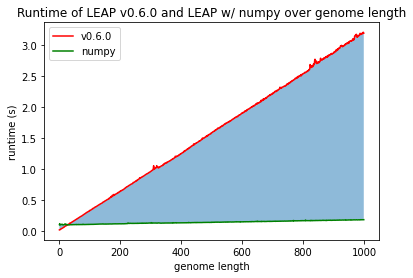

In [4]:
# THIS CELL IS SEPARATE FROM THE REST OF THE NOTEBOOK
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

numpy_data = pd.read_csv('0.7.0.dev_runtime.csv').values
list_data = pd.read_csv('0.6.0_runtime.csv').values
difference = list_data[:, -1] - numpy_data[:, -1]

plt.fill_between(np.arange(1, 1000), list_data[:, -1], numpy_data[:, -1], alpha=0.5)
plt.plot(np.arange(1, 1000), list_data[:, -1], c='red', label='v0.6.0')
plt.plot(np.arange(1, 1000), numpy_data[:, -1], c='green', label='numpy')
plt.title('Runtime of LEAP v0.6.0 and LEAP w/ numpy over genome length')
plt.xlabel('genome length')
plt.ylabel('runtime (s)')
plt.legend()
plt.savefig('runtime_difference_1000.png')
plt.show()